In [2]:
# import statements
from scipy.integrate import ode, solve_ivp # ordinary diff equations solver
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [159]:
class seir_model:
    """
    Intantiates a seir_model object.
    """

    def __init__(self, N=1e3, time_range=10, **kwargs):
        """
        Initializes the model with default parameters.

        Args:
            N (int, optional): [Population size]. Defaults to 1e3.
            time_range (int, optional): [Simulation time in days]. Defaults to 10.
        """    
        # initializes model parameters
        self.time_range = time_range # simulation duration in days
        self.beta = 0.3 # time varying transmission rate, initial value
        self.Z = 3.69 # average time, in days, for exposed to become infected
        self.alpha = 0.6 # reported infections rate (Ir/Ir+In)
        self.D = 7.0 # average time, in days, for the infection duration. 

        # initializes infection parameters
        self.N = N # initial number of individuals in the population
        self.S = 0.9 * N # initial number of susceptible individuals
        self.E = 0.4 * N # initial number of exposed individuals
        self.Ir = 0.4 * N # initial number of reported infected individuals
        self.In = 0.1 * N # initial number of non-reported infected individuals
        self.R = 0.01 * N # initial number of recovered

        for key, value in kwargs.items(): # updates model parameters, if any
            setattr(self, key, value)

        # checks if inputs are valid
        conditions = all([self.S <= self.N,
                          self.E <= self.N,
                          self.Ir <= self.N,
                          self.In <= self.N,
                          self.R <= self.N,
                          self.alpha > 0,
                          self.alpha <= 1,
                          self.beta >= 0,
                          self.beta <= 1])
        if conditions:
            self.solution = self.solve_seir_function()
        else:
            raise Exception('Parameters are not valid.')

    def seir_function(self, t, y, beta, Z, alpha, D):
        """
        Defines the function to be solved in the Initial Value Problem.

        Args:
            t (float): [Time to be varied]
            y ([array of floats]): [Contains the infection parameters]
            beta ([float]): [Transmission rate]
            Z ([float]): [Average time for infection, days]
            alpha ([float]): [Reported infections rate]
            D ([float]): [Average time for the infection duration, days]

        Returns:
            [array of floats]: [returns the deterministic equations]
        """        
        S, E, In, Ir, R = y

        # model compartments
        dSdt = (-self.beta/self.N) * S * (In+Ir) # susceptible individuals time varying rate
        dEdt = (self.beta/self.N) * S * (In+Ir) - (1/self.Z) * E # exposed individuals time varying rate
        dIrdt = (alpha/self.Z) * E - (1/self.D) * Ir # reported infections time varying rate
        dIndt = ((1-alpha)/self.Z) * E - (1/self.D) * In # non reported infections time varying rate
        dRdt = (1/self.D) * (In+Ir) # recovered individuals time varying rate

        return np.array([dSdt, dEdt, dIrdt, dIndt, dRdt])


    def solve_seir_function(self):
        """
        Solves the seir function based on initial values, uses scipy.integrate.

        Returns:
            [object]: [Solution object]
        """        
        solver = solve_ivp(self.seir_function,
                            [0, self.time_range],
                            [self.S, self.E, self.In, self.Ir, self.R],
                            # t_eval = np.array(range(self.time_range)),
                            method = 'RK45',
                            args = [self.beta, self.Z, self.alpha, self.D])
        return solver


    def plot_results(self, split_i=False):
        """
        Plots the results using matplotlib, based on object values.

        Args:
            split_i (bool, optional): [True if split between reported and non reported]. 
            Defaults to False.
        """        
       
        
        S_solved = self.solution.y[0]
        E_solved = self.solution.y[1]
        In_solved = self.solution.y[2]
        Ir_solved = self.solution.y[3]
        R_solved = self.solution.y[4]
        time_solved = self.solution.t

        fig, ax = plt.subplots(figsize=(15,5))
        if split_i:
            vals = [S_solved, E_solved, In_solved, Ir_solved, R_solved]
            labels = ['S', 'E', 'In', 'Ir', 'R']
        else:
            vals = [S_solved, E_solved, In_solved + Ir_solved, R_solved]
            labels = ['S', 'E', 'I', 'R']

        for var in vals:
            plt.plot(time_solved, var)

        plt.legend(labels)

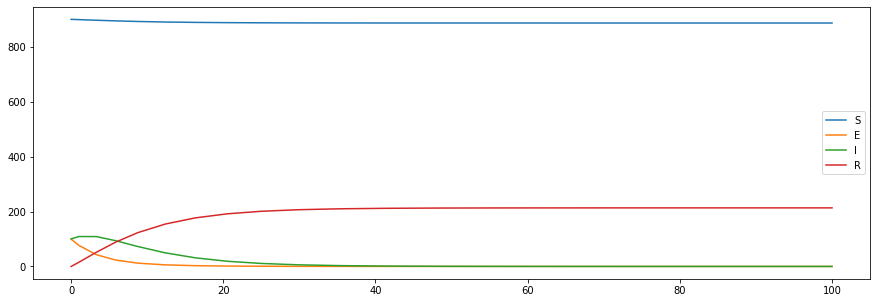

In [160]:
model = seir_model(N = 1000,
                   time_range = 100,
                   beta = 0.01,
                   alpha = 0.01,
                   S = 900,
                   E = 100,
                   In = 100,
                   Ir = 0,
                   R = 0)
model.plot_results()

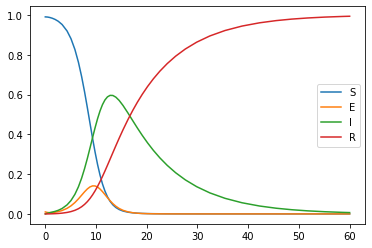

In [140]:
def seir_f(t, y, beta, sigma, gamma):
    s, e, i, r = y
    return np.array([-beta * i * s,
                     -sigma * e + beta * i * s, 
                     -gamma * i + sigma * e, 
                     gamma * i])

# try some parameter values
beta = 1
sigma = 1
gamma = 0.1

sol = solve_ivp(seir_f, [0, 60], [0.99, 0.01, 0, 0], 
                rtol=1e-6, args=(beta, sigma, gamma))

fig = plt.figure(); ax = fig.gca()
curves = ax.plot(sol.t, sol.y.T)
ax.legend(curves, ['S', 'E', 'I', 'R']);